# 4) XGBoost

Good tutorial xgboost:
    
https://www.datacamp.com/community/tutorials/xgboost-in-python

### 4. What is XGBoost?

slide with explanations:

### 4.) Load and prepare data for algorithm:

In [15]:
#import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
#import file with features:
xgbdata = pd.read_csv("df_features.csv")
xgbdata.head(5)

,class,sms,length,sw_count,sc_count,hyperlink,digit_count,phone,smileys,weeb,upper_case
0,0,"Go until jurong point, crazy.. Available only ...",111,32,8,False,0,False,0,False,3
1,0,Ok lar... Joking wif u oni...,29,6,6,False,0,False,0,False,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,43,1,False,25,True,0,False,10
3,0,U dun say so early hor... U c already then say...,49,17,6,False,0,False,0,False,2
4,0,"Nah I don't think he goes to usf, he lives aro...",61,18,0,False,0,False,0,False,2


In [17]:
#change False to 0 and True to 1:
#define function:
def bool_to_bin(colname):
    index_false = xgbdata.loc[:,colname]==False
    xgbdata.loc[index_false,colname]=0
    xgbdata.loc[-index_false,colname]=1

bool_to_bin("hyperlink")
bool_to_bin("phone")
bool_to_bin("weeb")

xgbdata = xgbdata.loc[:,["class","length","sc_count","sw_count","hyperlink","digit_count","smileys","upper_case"]]

xgbdata.head(5)

,class,length,sc_count,sw_count,hyperlink,digit_count,smileys,upper_case
0,0,111,8,32,0,0,0,3
1,0,29,6,6,0,0,0,2
2,1,155,1,43,0,25,0,10
3,0,49,6,17,0,0,0,2
4,0,61,0,18,0,0,0,2


In [18]:
#separate data in target and predictor variables:
X = xgbdata.iloc[:,1:]
y = xgbdata.iloc[:,0]

#transform into Dmatrix (faster and supported by xgboost):
dmatrix = xgb.DMatrix(data=X,label=y)

In [19]:
#make train test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=111)
#set seed in order to be able to reproduce results

### 4. Train model:

In [20]:
#generate classifier:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,num_boost_round=50)
#make prediction:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, num_boost_round=50,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### 4. Evaluate model:

In [21]:
%%capture
#CROSS VALIDATION 
params={"max_depth":5, "min_child_weight":2, "eta": 0.1, "subsamples":0.9, "colsample_bytree":0.8, "objective" : "binary:logistic", "eval_metric": ["error","logloss","auc"]}
rounds = 200

result = xgb.cv(params=params, nfold=5, dtrain=dmatrix, num_boost_round=rounds, as_pandas=True, seed=10,early_stopping_rounds=50)


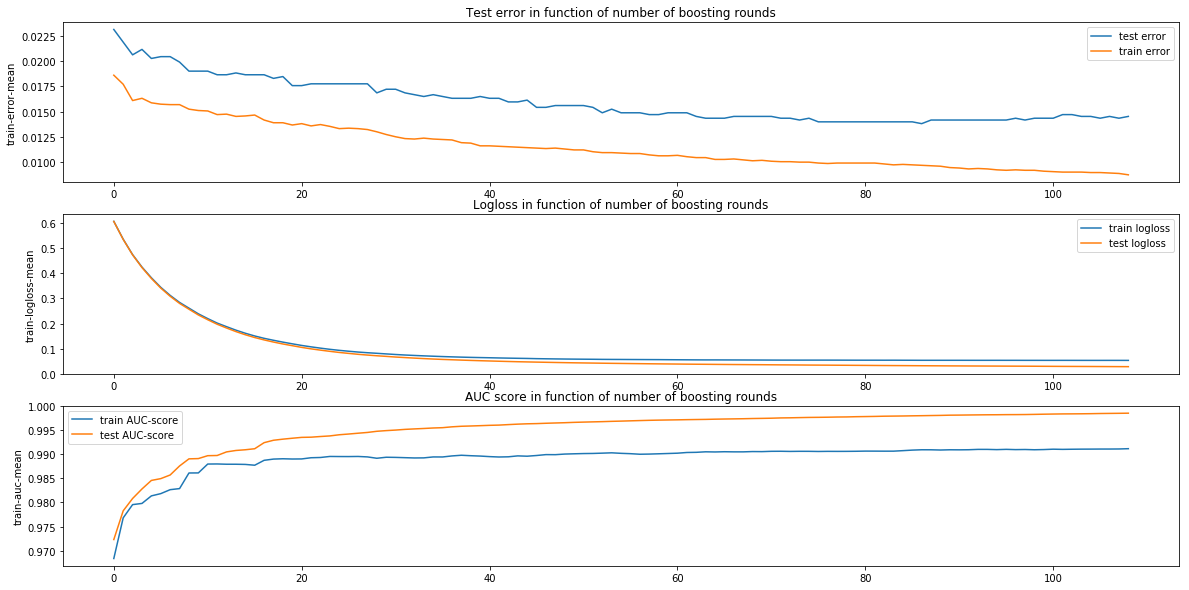

In [22]:
test_error = result.loc[:,"test-error-mean"]
train_error = result.loc[:,"train-error-mean"]
test_logloss = result.loc[:,"test-logloss-mean"]
train_logloss = result.loc[:,"train-logloss-mean"]
test_auc = result.loc[:,"test-auc-mean"]
train_auc = result.loc[:,"train-auc-mean"]
n = range(len(test_auc))

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

sns.lineplot(n,test_error,ax=ax1,label="test error")
sns.lineplot(n,train_error,ax=ax1, label="train error")
ax1.set_title("Test error in function of number of boosting rounds")
ax1.legend()

sns.lineplot(n,test_logloss,ax=ax2,label="train logloss")
sns.lineplot(n,train_logloss,ax=ax2,label="test logloss")
ax2.set_title("Logloss in function of number of boosting rounds")
ax2.legend()

sns.lineplot(n,test_auc,ax=ax3,label="train AUC-score")
sns.lineplot(n,train_auc,ax=ax3,label="test AUC-score")
ax3.set_title("AUC score in function of number of boosting rounds")
ax3.legend()

plt.show()

We see that all the metrics converge with the number of boosting rounds. There seems to be no issue with overfitting either. As such, lets chooser 50 boosting rounds for the following tests.

In [23]:
#TRAIN ERROR:
y_pred = xg_reg.predict(X_train)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy1 = accuracy_score(y_train, predictions)
l1 = log_loss(y_train, y_pred)
print("Accuracy for training: %.2f%%" % (accuracy1 * 100.0))
print("Logloss for training: ",l1)


Accuracy for training: 97.33%
Logloss for training:  0.28073484721432945


In [24]:
#TEST ERROR:
y_pred = xg_reg.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy2 = accuracy_score(y_test, predictions)
l2 = log_loss(y_test, y_pred)
print("Accuracy for test set: %.2f%%" % (accuracy2 * 100.0))
print("Logloss for training: ",l2)


Accuracy for test set: 97.58%
Logloss for training:  0.2769729296321826


C:\Users\rick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.9869299977114087


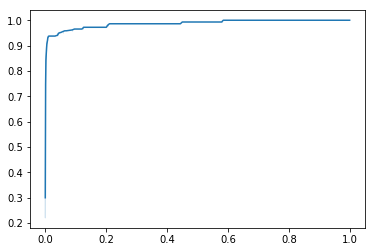

In [25]:
#plot area under the curve:
roc = roc_curve(y_test,y_pred)
x = roc[0]
y = roc[1]
sns.lineplot(x,y)
print(roc_auc_score(y_test,y_pred))


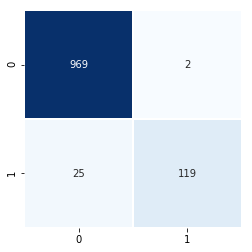

In [26]:
#generate a confusion matrix
cm = confusion_matrix(y_test,np.round(y_pred))
sns.heatmap(cm,annot=True,cbar=False,square=True,cmap='Blues',fmt='g',linewidths=0.5)


### 4. Test on unseen SMS

In [27]:
#invent 2 non-spam sms (easy and difficult):
sms1_non_spam = "Hey man, how you doin???"
sms2_non_spam = "Hello Eric, here's my other phone number: +33 661 29 77 66"
#invent 2 spam sms (easy and difficult):
sms1_spam = "CONGRATULATIONS, you won at the lottery! All you need to do is call us on the following number: +33 72 36 54 28. Or you can visit www.youwonlottery.com"
sms2_spam = "What a time to be alive! You can now buy the new Ray Ban sunglasses at a discount rate of -50%. Reply with -I want 50% off-"


### 4. Weaknesses and strengths of model:

early stopping to avoid overfitting??

https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [28]:

eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)


results = xg_reg.evals_result()
print(results)

[0]	validation_0-error:0.026912	validation_1-error:0.021525
[1]	validation_0-error:0.024893	validation_1-error:0.018834
[2]	validation_0-error:0.025791	validation_1-error:0.019731
[3]	validation_0-error:0.025342	validation_1-error:0.022422
[4]	validation_0-error:0.031621	validation_1-error:0.025112
[5]	validation_0-error:0.025791	validation_1-error:0.021525
[6]	validation_0-error:0.027136	validation_1-error:0.022422
[7]	validation_0-error:0.030052	validation_1-error:0.026009
[8]	validation_0-error:0.032743	validation_1-error:0.026906
[9]	validation_0-error:0.026688	validation_1-error:0.024215
{'validation_0': {'error': [0.026912, 0.024893, 0.025791, 0.025342, 0.031621, 0.025791, 0.027136, 0.030052, 0.032743, 0.026688]}, 'validation_1': {'error': [0.021525, 0.018834, 0.019731, 0.022422, 0.025112, 0.021525, 0.022422, 0.026009, 0.026906, 0.024215]}}
